In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import nivapy3 as nivapy

# Intro

Aim: prepare historic pan-Arctic discharge data for use in BEST-Siberian Arctic Ocean modelling.

End goal is to estimate freshwater and water chemistry inputs to the Arctic Ocean over the period 1980-2019 on a 20 km grid. Monitoring data will be used where possible, probably just from ArcticGRO (largest Arctic rivers). For all other grid cells, use RADR discharge reanalysis data.

Grid: the A20 ("Arctic ocean 20 km resolution") grid that Phil and Andre are already using, which is here: shared/pan_arctic_data/A20niva_grd_v1.nc

# RADR data

This is simulated discharge data for sub-catchments across the whole Arctic. Generated using two global hydrology models, and corrected using millions of remote sensing-derived discharge estimates. See Feng, D., Gleason, C.J., Lin, P., Yang, X., Pan, M., and Ishitsuka, Y., 2021, Recent changes to Arctic river discharge, Nature Communication.

In [ ]:
radr_path = r"~/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
ds = xr.open_dataset(radr_path)
ds

## Read in MERIT-Hydro basins shapefiles

The RADR 'reach' coordinate corresponds to basin IDs used in MERIT-Hydro. Therefore to get catchment and reach metadata for RADR, need to also load shapefiles from MERIT-Hydro. Two shapefiles are available, one with the catchment boundaries which includes areas, the other with the river network. The river network shapefile includes metadata on the spatial ordering of the catchments and upstream area.

Basin IDs use the Pfafstetter numbering convention from HydroSHEDS/HydroBASINS, aside from the first 3 levels which were input manually to indicate the continent, major region and major river basin.

In [3]:
cat_shp_path = r"~/shared/pan_arctic_data/merit_hydro_basins/cat_pfaf_3_MERIT_Hydro_v07_Basins_v01.shp"
merit_cat_gdf = gpd.read_file(cat_shp_path)
merit_cat_gdf.set_index('COMID', inplace=True)
merit_cat_gdf.head()

,COMID,unitarea,geometry
0,31000002,26.298253,"POLYGON ((75.77375 73.52042, 75.77458 73.52042..."
1,31000032,32.510215,"POLYGON ((71.05625 73.45375, 71.06042 73.45375..."
2,31000072,69.876275,"POLYGON ((69.34625 72.57542, 69.34708 72.57542..."
3,31000164,28.966191,"POLYGON ((69.59542 72.01625, 69.59708 72.01625..."
4,31000527,85.679412,"POLYGON ((72.45708 71.03208, 72.46625 71.03208..."


In [14]:
riv_shp_path = r"~/shared/pan_arctic_data/merit_hydro_basins/riv_pfaf_3_MERIT_Hydro_v07_Basins_v01.shp"
merit_riv_gdf = gpd.read_file(riv_shp_path)
merit_riv_gdf.set_index('COMID', inplace=True)
merit_riv_gdf.head()

,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
0,31000001,5.708578,4.262756,1.339175,0.000175,NaN,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (79.30500 74.62500, 79.30417 74.625..."
1,31000002,1.082424,0.652633,1.658550,0.001012,26.298253,1,1.1,0.001012,0,0,0,0,0,0,"LINESTRING (75.87167 73.51917, 75.87083 73.519..."
2,31000003,7.313123,4.688106,1.559931,0.000163,35.828614,1,1.2,0.000163,0,0,0,0,0,0,"LINESTRING (74.69167 73.02083, 74.69083 73.020..."
3,31000004,1.156125,0.896205,1.290023,0.000345,201.502489,2,0.4,0.000345,0,2,31000019,31000027,0,0,"LINESTRING (71.08833 73.33583, 71.08750 73.336..."
4,31000005,20.855677,8.653933,2.409965,0.000139,218.892441,2,2.9,0.000139,0,2,31000014,31000015,0,0,"LINESTRING (71.27667 73.23750, 71.27583 73.236..."


## Look at intersection of basin IDs and general QC

Find that RADR and MERIT reach/COMIDs are overlapping, i.e. MERIT COMIDs correspond to RADR reach IDs. Yay!

E.g. for Siberia (region 3), see that there is one more river ID than there is a catchment ID. That's weird, as can't have a river without a catchment?? Need to look into

In [32]:
print(len(merit_cat_ids), len(merit_riv_ids))

288612 288613


In [30]:
merit_cat_ids = set(merit_cat_gdf.index.astype(int).unique())
merit_riv_ids = set(merit_riv_gdf.index.astype(int).unique())
radr_ids = set(list(ds['reach'].data.astype(int)))

In [29]:
# How many MERIT catchment IDs are in RADR and how many are not?
cat_intersect = len(merit_cat_ids.intersection(radr_ids))
cat_not_intersect = len(merit_cat_ids - radr_ids)
print(cat_intersect, cat_not_intersect)
assert cat_intersect + cat_not_intersect == len(merit_cat_ids)

265060 23552


In [31]:
# How many MERIT river IDs are in RADR and how many are not?
riv_intersect = len(merit_riv_ids.intersection(radr_ids))
riv_not_intersect = len(merit_riv_ids - radr_ids)
print(riv_intersect, riv_not_intersect)
assert riv_intersect + riv_not_intersect == len(merit_riv_ids)

265060 23553


In [33]:
intersect_cat_ids = list(merit_cat_ids.intersection(radr_ids))
intersect_riv_ids = list(merit_riv_ids.intersection(radr_ids))

# Quick plot of a small portion to see if looks sensible

Pfafstetter splits major catchments into 9 subcatchments, and same again for each subcatchment, with a minimum size threshold. Therefore pick 1-9 from the last COMID digit (or order) and see whether they're nested subcatchments.

In [36]:
test_ids = intersect_cat_ids[:9]
test_ids

[32000001,
 32000002,
 32000003,
 32000004,
 32000005,
 32000006,
 32000007,
 32000008,
 32000009]

<AxesSubplot:>

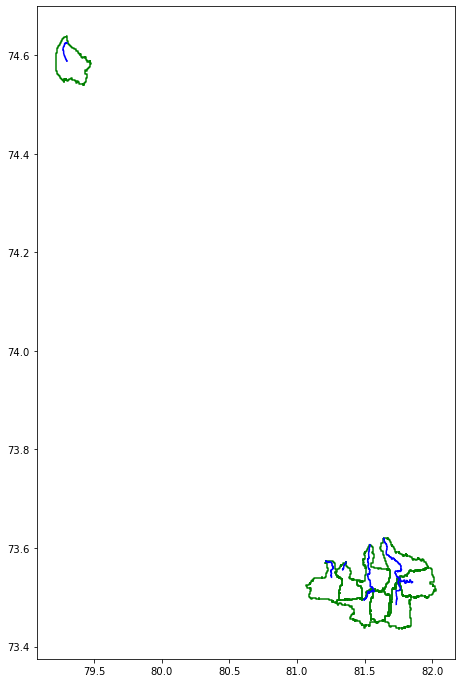

In [43]:
ax = merit_cat_gdf.loc[test_ids,:].boundary.plot(color='green', figsize=(12,12))
merit_riv_gdf.loc[test_ids,:].plot(color='blue', ax=ax)

Looks reasonable, except not sure what is happening with catchment 1. I guess it is an island, as it has no upstream or downstream area. If drop that, things look nicer:

<AxesSubplot:>

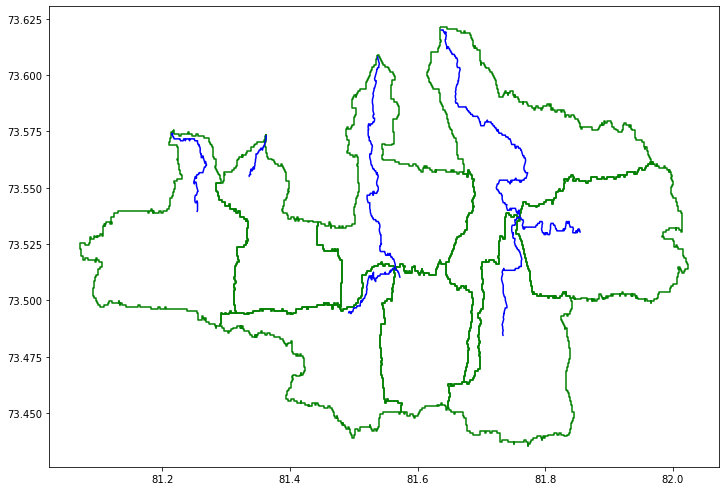

In [46]:
test_ids = intersect_cat_ids[1:9]
ax = merit_cat_gdf.loc[test_ids,:].boundary.plot(color='green', figsize=(12,12))
merit_riv_gdf.loc[test_ids,:].plot(color='blue', ax=ax)

# Next steps

## RADR data:
* Calculate monthly means from daily. This is what we will use, rather than daily.

## MERIT/RADR data:
* Have downloaded MERIT data (catchment and river shapefiles) for regions 2 (Europe), 3 (Siberia) and 8 (Arctic North America). Expect most of the basins in regions 3 and 8 to overlap with RADR. However, much of region 2 (Europe) will be outside RADR. In the future, may also want to download Greenland (Region 9), although this is not in RADR.
* For each region: discard any features where COMID is not in RADR
* Stitch the 3 regions together into one pan-Arctic strip?
* Identify "river to sea" catchments
* Associate "river to sea" catchments with appropriate grid square in A20 grid, and set runoff time series for that grid square
* Derive shapefiles for river-to-sea catchment boundaries. i.e. dissolve/join sub-catchments within the same bigger river network. Not sure how to do this - maybe using the Pfafstetter numbering?
* Derive a shapefile for the whole Arctic Ocean catchment used by RADR, by merging all MERIT-RADR catchments

## ArcticGRO observed discharge data:
* Have downloaded data: r'../discharge/ArcticGRO/data'
* Locations of discharge sampling sites: r'../ArcticGRO_spatial_data/sampling_locations_discharge.csv'
* Associate sampling point with RADR basin
* If Q is measured a long way up-stream of the outflow to the sea, then area-scale measured Q to estimate Q at outflow. Leah to do: find estimates of catchment areas for ArcticGRO monitoring points and add to sampling_locations_discharge.csv
* Leah working on cleaning the time series (interpolating small gaps, generating just one time series where several gauges are available on the same river).
* Once have clean monthly time series for each ArcticGRO site: replace RADR data for the A20 grid square with observed Q time series.

## Extras
* Use derived river-to-sea catchment boundaries, plus lots of nice spatial data, to calculate catchment properties. Need to gather the data, but hopefully including things like slope, elevation, permafrost extent, land cover, soil C store, climate.
* Stats between observed discharge and chem and catchment properties. Look at possible drivers of spatial and temporal differences/trends, and then hopefully to extrapolate observations spatially and maybe temporally.